# Transporte Quântico Mesoscópico

## Quantum Matter - Materials & Concepts Summer School 2021

### Sessão prática

Nesta sessão, vamos calcular a autoenergia de contactos semi-infinitas de usando diferentes métodos numéricos, e usar esses resultados para calcular a transmissão através sistema de um único nível. 

Para tornar o problema concreto vamos focar-nos num cadeia de tight-binding de uma orbital com hoppings a primeiros vizinhos. A vantagem deste modelo, é que várias quantidades podem ser calculadas analiticamente, podendo servir de padrão para os resultados numéricos. (Podes tentar contactos mais gerais)

Para resolver o problema usando Julia é conveninente carregar o pacote `LinearAlgebra`, para resolver problemas de algebra linear, e instalar e carregar uma biblioteca de plotting. Vamos usar o `PyPlot`.

In [15]:
using LinearAlgebra, StaticArrays

In [3]:
using PyPlot

## 1. Cálculo da estrutura de bandas de um sistema 1D

Consideremos um sistema 1D invariante de translação. Este pode ser escrito como:

$$
H_{\text{infinito}}=\left[\begin{array}{cccccc}
 & \ddots\\
\ddots & \ddots & \boldsymbol{v}\\
 & \boldsymbol{v}^{\dagger} & \boldsymbol{h} & \boldsymbol{v}\\
 &  & \boldsymbol{v}^{\dagger} & \boldsymbol{h} & \boldsymbol{v}\\
 &  &  & \boldsymbol{v}^{\dagger} & \ddots & \ddots\\
 &  &  &  & \ddots
\end{array}\right].
$$

Para calcular a estrutura de bandas, devemos resolver o problema de valores próprios:

$$
\left(\boldsymbol{h}+e^{ik}\boldsymbol{v}+e^{-ik}\boldsymbol{v}^{\dagger}\right)\Psi_{k}=E_{k}\Psi_{k}.
$$

### Exercício 1.1.
Escreve uma função que dado as matrizes $\boldsymbol{h}$ e $\boldsymbol{v}$ calcule a estrutura de bandas 1D.

Por conveniência podemos guardar o Hamiltoniano numa estrutura:

In [4]:
struct SemiInfiniteLead{Th, Tv}
    h::Th
    v::Tv
end

mat(x::Number) = fill(x, 1, 1)
mat(A::AbstractMatrix) = A
SemiInfiniteLead(e::Number, t::Number) = SemiInfiniteLead(mat(e), mat(t))

dimh(lead::SemiInfiniteLead) = size(lead.h, 2)
;

Uma cadeia simples 1D com $\boldsymbol{h} = 0$ e $\boldsymbol{v}=-t$ pode ser definida como:

In [5]:
chain = SemiInfiniteLead(0.0, -1.0)
;

In [6]:
function spectrum(lead::SemiInfiniteLead, k)
    
    Hk = lead.h + lead.v*cis(k) + lead.v'*cis(-k)
    
    energies = eigvals(Hermitian(Hk))
    
    return energies
end


function bandstructure(lead::SemiInfiniteLead, kpts)
    
    bands = zeros(dimh(lead), length(kpts))
    
    for (i, k) in enumerate(kpts)
        
        bands[:, i] = spectrum(lead, k)
    
    end
    
    return bands
    
end 

bandstructure (generic function with 1 method)

In [7]:
kpts = range(-pi, stop =  pi, length = 100)
bandas = bandstructure(chain, kpts)

1×100 Matrix{Float64}:
 2.0  1.99597  1.98391  1.96386  1.9359  …  1.96386  1.98391  1.99597  2.0

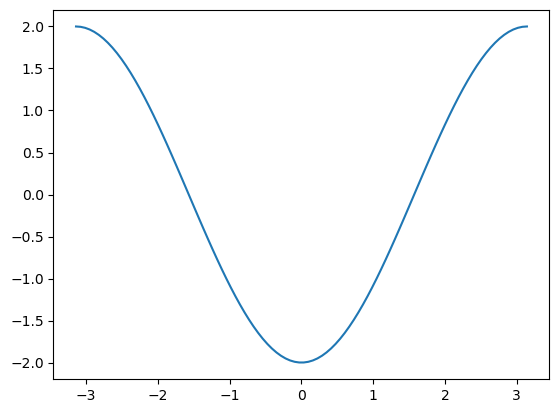

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f8ceb8d2550>

In [8]:
plot(kpts, bandas[1, :])

## 2. Cálculo recursivo da auto-energia

Consideremos agora um contacto semi-infitio, com Hamiltoniano dado por:

$$
H_{\text{semi}}=\left[\begin{array}{cccc}
\boldsymbol{h} & \boldsymbol{v}\\
\boldsymbol{v}^{\dagger} & \boldsymbol{h} & \boldsymbol{v}\\
 & \boldsymbol{v}^\dagger & \ddots & \ddots\\
 & \ddots
\end{array}\right]
$$

Queremos calcular a auto-energia: $\Sigma^R = \boldsymbol{v}\boldsymbol{g}_{1,1}^R \boldsymbol{v}^\dagger$,

onde a função de Green é a solução de:

$$
\left[\begin{array}{cccc}
E-\boldsymbol{h} & -\boldsymbol{v}\\
-\boldsymbol{v}^{\dagger} & E-\boldsymbol{h} & -\boldsymbol{v}\\
 & -\boldsymbol{v}^{\dagger} & \ddots & \ddots\\
 &  & \ddots
\end{array}\right]\left[\begin{array}{cccc}
\boldsymbol{g}_{1,1}^{R} & \boldsymbol{g}_{1,2}^{R} & \boldsymbol{g}_{1,3}^{R} & \cdots\\
\boldsymbol{g}_{2,1}^{R} & \boldsymbol{g}_{2,2}^{R} & \boldsymbol{g}_{2,3}^{R} & \cdots\\
\boldsymbol{g}_{3,1}^{R} & \boldsymbol{g}_{3,2}^{R} & \boldsymbol{g}_{3,3}^{R} & \cdots\\
\vdots & \vdots & \vdots & \ddots
\end{array}\right]=\left[\begin{array}{cccc}
\boldsymbol{1}\\
 & \boldsymbol{1}\\
 &  & \boldsymbol{1} & \ddots\\
 &  & \ddots & \ddots
\end{array}\right]
$$

O método recursivo baseia-se no facto de que uma cadeia semi-infinita pode ser vista como um sítio acoplado a uma cadeia semi-infinita. Tratando a hibridização entre o primeiro sítio e o resto da cadeia como uma perturbação, podemos então escrever as equações de Dyson:

$$
\begin{align*}
\boldsymbol{g}^{R} & =\tilde{\boldsymbol{g}}^{R}+\tilde{\boldsymbol{g}}^{R}\cdot\boldsymbol{V}\cdot\boldsymbol{g}^{R}\\
\boldsymbol{g}^{R} & =\tilde{\boldsymbol{g}}^{R}+\boldsymbol{g}^{R}\cdot\boldsymbol{V}\cdot\tilde{\boldsymbol{g}}^{R}
\end{align*}
$$

Onde:
$$
\tilde{\boldsymbol{g}}^{R}=\left[\begin{array}{cccc}
E-\boldsymbol{h} & \boldsymbol{0}\\
\boldsymbol{0} & E-\boldsymbol{h} & -\boldsymbol{v}\\
 & -\boldsymbol{v}^{\dagger} & \ddots & \ddots\\
 &  & \ddots
\end{array}\right]^{-1}
$$

é a função de Green para o sistema em que o primeiro sítio está desconectado do resto do contacto e
$$
\boldsymbol{V}=\left[\begin{array}{cccc}
\boldsymbol{0} & \boldsymbol{v}\\
\boldsymbol{v}^{\dagger} & \boldsymbol{0} & \boldsymbol{0}\\
 & \boldsymbol{0} & \boldsymbol{0} & \ddots\\
 &  & \ddots & \ddots
\end{array}\right]
$$

liga o primeiro sítio ao resto do contacto.

A partir daqui obtemos as seguintes relações:
$$
\begin{align*}
\boldsymbol{g}_{1,1}^{R} & =\tilde{\boldsymbol{g}}_{1,1}^{R}+\tilde{\boldsymbol{g}}_{1,1}^{R}\cdot\boldsymbol{V}_{1,2}\cdot\boldsymbol{g}_{2,1}^{R}\\
\boldsymbol{g}_{2,1}^{R} & =\tilde{\boldsymbol{g}}_{2,2}^{R}\cdot\boldsymbol{V}_{2,1}\cdot\boldsymbol{g}_{1,1}^{R}
\end{align*}
$$
De onde obtemos a equação:
$$
\boldsymbol{g}_{1,1}^{R}=\left[E-\boldsymbol{h}-\boldsymbol{v}\cdot\tilde{\boldsymbol{g}}_{2,2}^{R}\cdot\boldsymbol{v}^{\dagger}\right]^{-1}
$$

Parece que não avançamos muito, porque não sabemos calcular $\tilde{\boldsymbol{g}}^R_{2,2}$. No entanto, $\tilde{\boldsymbol{g}}^R_{2,2}$ é exactamente a quantidade que queremos calcular: a função de Green de um contacto semi-infinito, avaliada na fronteira do contacto. Logo, temos que $$\tilde{\boldsymbol{g}}^R_{2,2} = \boldsymbol{g}^R_{1,1}$$

e obtemos a seguinte equação auto-consistente:
$$
\boldsymbol{g}_{1,1}^{R}=\left[E-\boldsymbol{h}-\boldsymbol{v}\cdot\boldsymbol{g}_{1,1}^{R}\cdot\boldsymbol{v}^{\dagger}\right]^{-1}
$$

Que podemos usar para calcular a função de Green do contacto.

### Exercício 2.1. 
Para o caso partícular, de uma cadeia simples, reduza a equação anterior a uma equação quadrática para $g_{1,1}^R$. Das duas soluções possíveis, obtenha a função retardada de tal forma a que tomando uma energia complex $E + i \eta$, com $\eta \rightarrow 0^+$, a parte imaginária é negativa. 

Obtenha: 
$$
g^{R}(E)=\frac{1}{t}\left[\left(\frac{E-\epsilon_{0}}{2t}\right)-i\sqrt{1-\left(\frac{E+i0^{+}-\epsilon_{0}}{2t}\right)^{2}}\right]
$$


Estude a função de Green para $\left|E-\epsilon_{0}\right|\lessgtr2t$ e faça um plot das partes real e imaginária.

In [9]:
function gr(E)
    
    if abs(E) < 2
        
        return E/2 - 1im*sqrt(1-(E/2)^2)
        
    else
        
        return E/2 - sign(E)*sqrt((E/2)^2-1)
        
    end
    
end

gr (generic function with 1 method)

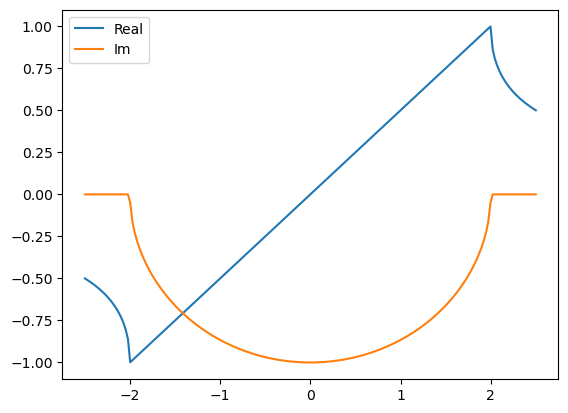

PyObject <matplotlib.legend.Legend object at 0x7f8cfcfcc880>

In [10]:
Es = range(-2.5, 2.5, length = 200)
grs = gr.(Es)

plot(Es, real.(grs), label = "Real")
plot(Es, imag.(grs), label = "Im")
legend()

### Exercício 2.2. 
Implemente um código que resolva a relação auto-consistente de forma iterativa. Compare o resultado numérico com o resultado analítico. 
**Dica:** Adicione uma pequena parte imaginária positiva à energia para estabilizar o método iterativo, $E \rightarrow E + i \eta$

In [26]:
function lead_selfenergy_recursive(lead::SemiInfiniteLead, E; eta = 0.01, niter = 200)
    
    gold = inv((E + im*eta)*I - lead.h)
    gnew = inv((E + im*eta)*I - lead.h - lead.v*gold*lead.v')
    η = eta
    for n in 1:niter
        
        gold = gnew
        gnew = inv((E + im*η)*I - lead.h - lead.v*gold*lead.v')
        
    end
    
    return gnew
end

lead_selfenergy_recursive (generic function with 1 method)

In [12]:
Es = range(-2.5, 2.5, length = 200)
selfenergy_recursive = [lead_selfenergy_recursive(chain, E; eta = 0.01, niter = 1000) for E in Es]
;

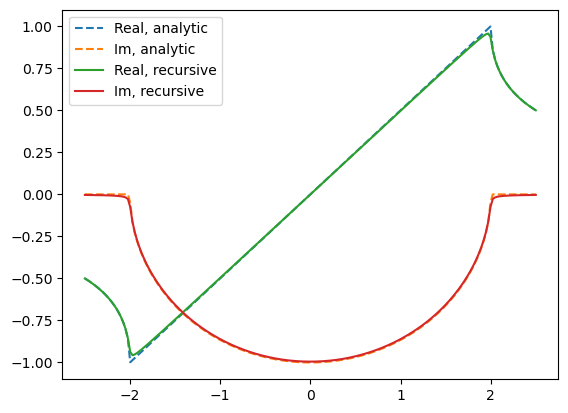

PyObject <matplotlib.legend.Legend object at 0x7f8cfcfb8e80>

In [13]:
plot(Es, real.(grs), label = "Real, analytic", "--")
plot(Es, imag.(grs), label = "Im, analytic", "--")

plot(Es, [real.(g[1]) for g in selfenergy_recursive], label = "Real, recursive")
plot(Es, [imag.(g[1]) for g in selfenergy_recursive], label = "Im, recursive")
legend()

In [18]:
ABchain = SemiInfiniteLead(SA[0.0 -1.0; -1.0 0.0], SA[0.0 0.0; -1.0 0.0])

SemiInfiniteLead{SMatrix{2, 2, Float64, 4}, SMatrix{2, 2, Float64, 4}}([0.0 -1.0; -1.0 0.0], [0.0 0.0; -1.0 0.0])

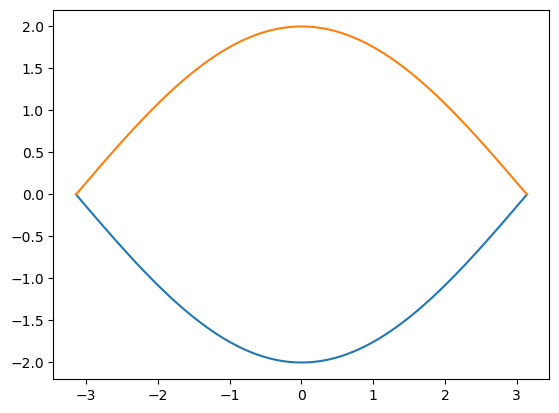

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f8ceb83a340>

In [20]:
kpts = range(-pi, stop =  pi, length = 100)
bandasAB = bandstructure(ABchain, kpts)

plot(kpts, bandasAB[1, :])
plot(kpts, bandasAB[2, :])

In [34]:
Es = range(-2.5, 2.5, length = 200)
gAB = [lead_selfenergy_recursive(ABchain, E; eta = 0.01, niter = 1000) for E in Es]
;

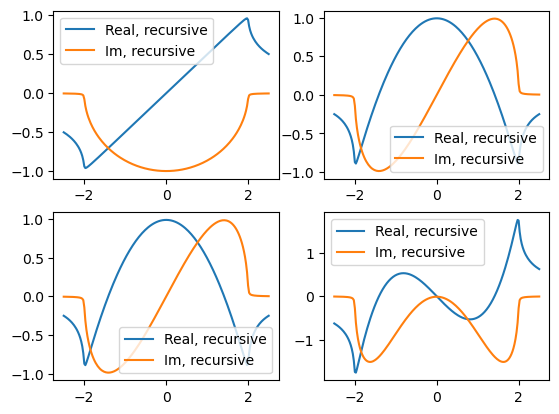

In [35]:
f, ax = subplots(2, 2)
for j in 1:2, i in 1:2
    ax[i, j].plot(Es, [real.(g[i, j]) for g in gAB], label = "Real, recursive")
    ax[i, j].plot(Es, [imag.(g[i, j]) for g in gAB], label = "Im, recursive")
    ax[i,j].legend()
end

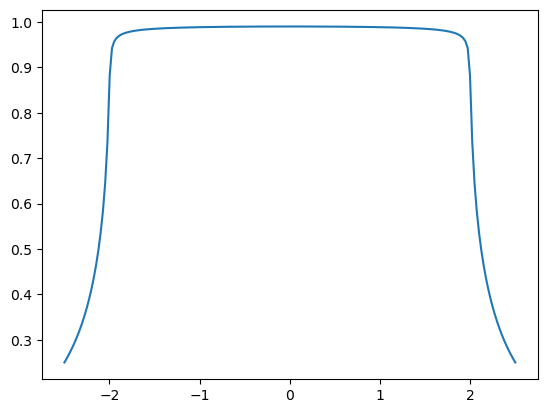

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f8ce8a9f700>

In [42]:
det_gAB = [det(g) for g in gAB]

plot(Es, abs.(det_gAB))

In [39]:
S

2-element SVector{2, Float64} with indices SOneTo(2):
 1.6849693827044023
 0.5873927390584103

## 3. Cálculo dos estados propagantes

Vamos agora calcular os estados propagantes. Recordemos que estes são solução de:
$$
-\boldsymbol{v}^{\dagger}\lambda^{-1}\Psi_{n-1}+\left(E-\boldsymbol{h}\right)\Psi_{n}=\lambda\boldsymbol{v}\Psi_{n}
$$

Que pode ser transformada no problema de valores próprios generalizado:
$$
\left[\begin{array}{cc}
\boldsymbol{0} & \boldsymbol{1}\\
-\boldsymbol{v}^{\dagger} & \left(E-\boldsymbol{h}\right)
\end{array}\right]\left[\begin{array}{c}
\Psi_{n-1}\\
\Psi_{n}
\end{array}\right]=\lambda\left[\begin{array}{cc}
\boldsymbol{1} & \boldsymbol{0}\\
\boldsymbol{0} & \boldsymbol{v}
\end{array}\right]\left[\begin{array}{c}
\Psi_{n-1}\\
\Psi_{n}
\end{array}\right]
$$.

### Exercício 3.1.
Definida uma função que dados $\boldsymbol{h}$ e $\boldsymbol{v}$, construa o problema de valores próprios generalizado e o resolva. Compare os valores próprios obtidos com o resultado analítico.

In [40]:
function leadstates_eigenproblem(lead::SemiInfiniteLead, E)
    n = dimh(lead)
    T = promote_type(eltype(lead.h), eltype(lead.v))
    
    A = [
        zeros(T, n, n) Matrix{T}(I, n, n);
        -lead.v' E*I-lead.h
    ]
    
    B = [
        Matrix{T}(I, n, n) zeros(T, n, n);
        zeros(T, n, n) lead.v
    ]
    
    vals, vecs = eigen(A, B)
    
    return vals, vecs
    
end

leadstates_eigenproblem (generic function with 1 method)

In [41]:
vals, vecs = leadstates_eigenproblem(chain, 0.2)

vecs

2×2 Matrix{ComplexF64}:
   0.913252-0.0im         0.913252+0.0im
 -0.0913252-0.908675im  -0.0913252+0.908675im

In [42]:
lambda_analytic(E) = [-(E/2) + 1im*sqrt(1-(E/2)^2), -(E/2) - 1im*sqrt(1-(E/2)^2)]  

lambda_analytic (generic function with 1 method)

In [43]:
lambda_analytic(0.2)

2-element Vector{ComplexF64}:
 -0.1 + 0.99498743710662im
 -0.1 - 0.99498743710662im

In [44]:
vals

2-element Vector{ComplexF64}:
 -0.10000000000000002 - 0.99498743710662im
 -0.10000000000000002 + 0.99498743710662im

### Exercício 3.2.
Recordando que os valores próprios, obtidos no exercício anterior, têm a forma:
$$
\left[\begin{array}{c}
\Psi_{n-1}\\
\Psi_{n}
\end{array}\right]
$$

Vamos escolher a seguinte normalização: $\Psi^{\dagger}\cdot\Psi=1$. 
Com esta normalização, calcule o operador de corrente:

$$
\left\langle \Psi_{\alpha}\left|I\right|\Psi_{\beta}\right\rangle =i\Psi_{\alpha}^{\dagger}\left(\lambda_{\beta}\boldsymbol{v}-\lambda_{\alpha}^{*}\boldsymbol{v}^{\dagger}\right)\Psi_{\beta}
$$

Verifique se a matriz é diagonal (ou diagonal por blocos). Compare as velocidades obtidas desta forma, com o resultado analítico.

In [53]:
function normalize_states(states)
    
    nstates = size(states, 2)
    n = div(nstates, 2)
    
    for α in 1:nstates
        normalization = norm(states[1:n, α])
        states[:, α] /= normalization
    end
    
    return states[1:n, :]
end

normalize_states (generic function with 1 method)

In [61]:
function current_matrix(lead::SemiInfiniteLead, Ψs, λs)
    
    nstates = size(Ψs, 2)
    J = Matrix{ComplexF64}(undef, nstates, nstates)
    
    for j in 1:nstates
        for i in 1:nstates     
            J[i, j] = 1im*(Ψs[:, i])'*(λs[j]*lead.v - conj(λs[i])*lead.v')*Ψs[:, j]
        end
    end
    
    #velocities, vecs = eigen(Hermitian(J))

    #return velocities, Ψs*vecs
    return J
end

current_matrix (generic function with 1 method)

In [66]:
λs[1]

-2.6180339887498945

In [67]:
1/λs[1]

-0.3819660112501052

In [73]:
λs, states = leadstates_eigenproblem(chain, 7.0)
Ψs = normalize_states(states)
v = current_matrix(chain, Ψs, λs)

2×2 Matrix{ComplexF64}:
 0.0+0.0im     0.0-6.7082im
 0.0+6.7082im  0.0+0.0im

In [72]:
Ψs

1×2 Matrix{Float64}:
 1.0  1.0

In [71]:
eigen(v)

Eigen{ComplexF64, Float64, Matrix{ComplexF64}, Vector{Float64}}
values:
2-element Vector{Float64}:
 -6.70820393249937
  6.70820393249937
vectors:
2×2 Matrix{ComplexF64}:
       0.0-0.707107im       0.0-0.707107im
 -0.707107+0.0im       0.707107+0.0im

In [48]:
λs, states = leadstates_eigenproblem(chain, 0.2)

(ComplexF64[-0.10000000000000002 - 0.99498743710662im, -0.10000000000000002 + 0.99498743710662im], ComplexF64[0.9132524868434898 - 0.0im 0.9132524868434898 + 0.0im; -0.09132524868434899 - 0.9086747513156511im -0.09132524868434899 + 0.9086747513156511im])

In [49]:
function leadstates(lead::SemiInfiniteLead, E)
    
    λs, states = leadstates_eigenproblem(lead, E)
    
    Ψs = normalize_states(states)
    
    velocties, Ψv = current_matrix(chain, Ψs, λs)
    
    # sort states by by |λ| and then by velocity (from largest to smallest):
    p = sortperm(collect(zip(velocties, λs)), by = x -> (abs(x[2]), -x[1]))
    
    return λs[p], velocties[p], Ψv[:, p]
    
end

leadstates (generic function with 1 method)

## 4. Cálculo da auto-energia do contacto através de estados propagantes

Vamos agora calcular a auto-energia, usando o resultado:

$$
\boldsymbol{\Sigma}^R = \boldsymbol{v} \cdot \boldsymbol{\Psi}_{out} \cdot \boldsymbol{\Lambda}_{out} \cdot \boldsymbol{\Psi}_{out}^{-1}
$$

Onde `out` refere-se a estados com velocidade positiva, ou com $|\lambda|<1$, isto é estados que se propagam para dentro da lead e, logo, para fora da região central (outgoing states).

### Exercícío 4.1.
Tomado apenas os estados outgoing (com velocidade positiva, ou $|\lambda|<1$), use a equação anterior para calcular numericamente a auto-energia. Compare o resultado obtido, com o resultado analítico e o resultado obtido usando o método recursivo. 

In [50]:
function lead_selfenergy_states(lead::SemiInfiniteLead, E)
    
    λs, velocities, Ψ = leadstates(lead::SemiInfiniteLead, E)

    nout = div(size(Ψ, 2), 2)
    Ψout = Ψ[:, 1:nout]
    
    return lead.v*Ψout*Diagonal(λs[1:nout])*inv(Ψout)
    
end

lead_selfenergy_states (generic function with 1 method)

In [51]:
Es = range(-2.5, 2.5, length = 200)
selfenergy_states = [lead_selfenergy_states(chain, E) for E in Es]
;

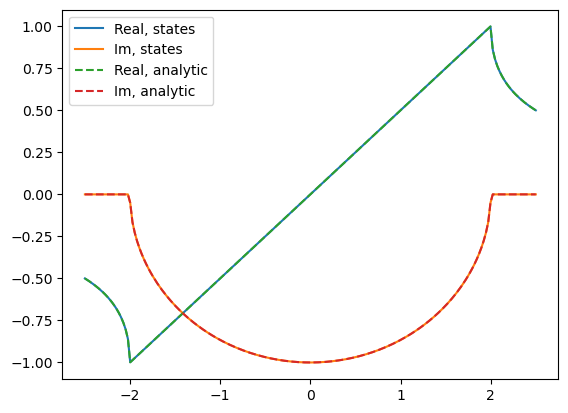

PyObject <matplotlib.legend.Legend object at 0x7f9ddfff7df0>

In [52]:
plot(Es, [real.(g[1]) for g in selfenergy_states], label = "Real, states")
plot(Es, [imag.(g[1]) for g in selfenergy_states], label = "Im, states")

plot(Es, real.(grs), label = "Real, analytic", "--")
plot(Es, imag.(grs), label = "Im, analytic", "--")

legend()

## 5. Transporte usando a fórmula de Caroli

Consideremos o sistema de dois contactos que é decrito pelo Hamiltoninao:
$$
H_{2-\text{contactos}}=\left[\begin{array}{ccccc}
\boldsymbol{H}_{C} & \boldsymbol{V}_{C,L} & \boldsymbol{V}_{C,R}\\
\boldsymbol{V}_{L,C} & \boldsymbol{h}_{L} &  & \boldsymbol{v}_{L}\\
\boldsymbol{V}_{R,C} &  & \boldsymbol{h}_{R} &  & \boldsymbol{v}_{R}\\
 & \boldsymbol{v}_{L}^{\dagger} &  & \boldsymbol{H}_{L,\text{semi}} & \\
 &  & \boldsymbol{v}_{R}^{\dagger} &  & \boldsymbol{H}_{R,\text{semi}}
\end{array}\right]
$$

Onde incluímos um sítio de cada cadeia na região central. No formalismo de Caroli tal não é necessário, mas fazemo-lo para fazer a relação com o formalismo de Landauer-Büttiker.

A fórmula de Caroli escreve a transmitância como:

$$
\mathcal{T}(E)=\text{Tr}\left[\boldsymbol{G}^{A}(E)\boldsymbol{\Gamma}_{R}(E)\boldsymbol{G}^{R}(E)\boldsymbol{\Gamma}_{L}(E)\right]
$$

onde

$$
\boldsymbol{G}^{R}(E)=\left[\begin{array}{ccc}
E-\boldsymbol{H}_{C} & -\boldsymbol{V}_{C,L} & -\boldsymbol{V}_{C,R}\\
-\boldsymbol{V}_{L,C} & E-\boldsymbol{h}_{L}-\boldsymbol{\Sigma}_{L}^{R}(E)\\
-\boldsymbol{V}_{R,C} &  & E-\boldsymbol{h}_{R}-\boldsymbol{\Sigma}_{R}^{R}(E)
\end{array}\right]^{-1},
$$

$\boldsymbol{G}^{A}(E)=\left[\boldsymbol{G}^{R}(E)\right]^{\dagger}$ e

$$
\begin{align*}
\boldsymbol{\Gamma}_{L}(E) & =\left[\begin{array}{ccc}
0 & 0 & 0\\
0 & i\left(\boldsymbol{\Sigma}_{L}^{R}(E)-\boldsymbol{\Sigma}_{L}^{A}(E)\right) & 0\\
0 & 0 & 0
\end{array}\right]\\
\boldsymbol{\Gamma}_{R}(E) & =\left[\begin{array}{ccc}
0 & 0 & 0\\
0 & 0 & 0\\
0 & 0 & i\left(\boldsymbol{\Sigma}_{R}^{R}(E)-\boldsymbol{\Sigma}_{R}^{A}(E)\right)
\end{array}\right]
\end{align*}
$$

### Exercício 5.1.
Implemente as equações anteriores de forma a calcular a transmitância. Use-as para calcular a transmitância através de um sítio de energia $\epsilon_0 = 0.5$, que está ligadas a contactos direitos e esquerdos com o hopping $t_{C,L} = t_{C, R} = -0.2$. Os contactos direito e esquerdo vão idênticos com energia onsite = 0 e hopping a primeiros vizinhos -1.

In [27]:
struct TwoTerminalSystem{Thc, Tcl, Tcr, Tll, Trl}
    Hc::Thc
    Vcl::Tcl
    Vcr::Tcr
    LeftLead::Tll
    RightLead::Trl
end

In [76]:
function transmitance_caroli(sys::TwoTerminalSystem, E)
    nL = dimh(sys.LeftLead)
    nR = dimh(sys.RightLead)
    nC = size(sys.Hc, 2)
    
    λleft, Vleft, Ψleft = leadstates(sys.LeftLead, E)
    noutL = div(size(Ψleft, 2), 2)
    ΨoutL = Ψleft[:, 1:noutL]
    Σleft = sys.LeftLead.v*ΨoutL*Diagonal(λleft[1:noutL])*inv(ΨoutL)
    
    λright, Vright, Ψright = leadstates(sys.RightLead, E)
    noutR = div(size(Ψright, 2), 2)
    ΨoutR = Ψright[:, 1:noutR]
    Σright = sys.RightLead.v*ΨoutR*Diagonal(λright[1:noutR])*inv(ΨoutR)
    
    L = [
        E*I-sys.Hc -sys.Vcl -sys.Vcr;
        -sys.Vcl' E*I-sys.LeftLead.h-Σleft zeros(nL, nR);
        -sys.Vcr' zeros(nR, nL) E*I-sys.RightLead.h-Σright
    ]

    Γleft = [zeros(nC, nL); 1im*(Σleft-Σleft'); zeros(nR, nL)]
    Ileft = [zeros(nC, nL); Matrix(I, nL, nL); zeros(nR, nL)]
    
    Γright = [zeros(nC, nR); zeros(nL, nR); 1im*(Σleft-Σleft')]
    Iright = [zeros(nC, nR); zeros(nL, nR); Matrix(I, nR, nR)]
    
    
    Qleft = L\Γleft
    Qright = L\Ileft
    
    return real(tr(Iright'Qleft*Qright'Γright))
end

transmitance_caroli (generic function with 1 method)

In [88]:
hc = fill(0.7, 1, 1)
Vcl = fill(-0.5, 1, 1)
Vcr = fill(-0.5, 1, 1)
leftlead = SemiInfiniteLead(0, -1)
rightlead = SemiInfiniteLead(0, -1)

twoterminal = TwoTerminalSystem(hc, Vcl, Vcr, leftlead, rightlead)
;

In [89]:
Es = range(-2, 2, length = 200)
Tcaroli = [transmitance_caroli(twoterminal, E) for E in Es]
;

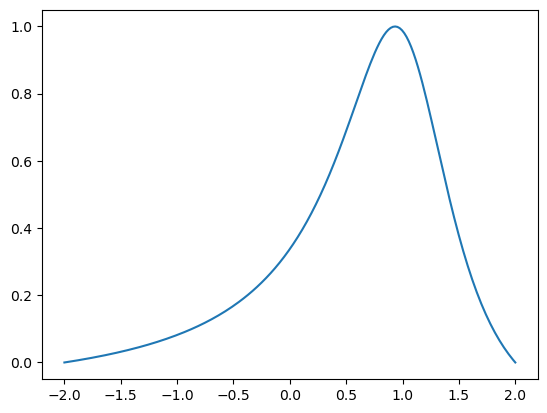

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f74be1ff4c0>

In [90]:
plot(Es, Tcaroli) 

### Exercício 5.2.
Compare a tarnsmitância calculada anteriormente com o transmitância obtida usando a fórmula de Landauer:

$$
\mathcal{T}(E)=\text{Tr}\left[\tilde{\boldsymbol{t}}_{R\leftarrow L}^{\dagger}\cdot\tilde{\boldsymbol{t}}_{R\leftarrow L}\right]
$$
onde
$$
\tilde{\boldsymbol{t}}_{R\leftarrow L}=i\boldsymbol{V}_{R}^{-1/2}\cdot\boldsymbol{\Psi}_{R,\text{out},p}^{\dagger}\cdot\boldsymbol{\Gamma}_{R}\cdot\boldsymbol{G}^{R}\cdot\boldsymbol{\Gamma}_{L}\cdot\boldsymbol{\Psi}_{L,\text{in},p}\cdot\boldsymbol{V}_{L}^{-1/2}
$$

e $\boldsymbol{V}_{L/R}$ são matrizes diagonais das velocidades e o indice `p` significa que apenas estados propagantes (com velocidade diferente de 0) entram na equação.

In [129]:
function transmitance_landauer(sys::TwoTerminalSystem, E)
    # we are assuming all states have non zero velocity. In practice, we should remove states with zero velocity
    nL = dimh(sys.LeftLead)
    nR = dimh(sys.RightLead)
    nC = size(sys.Hc, 2)
    
    λleft, vleft, Ψleft = leadstates(sys.LeftLead, E)
    noutL = div(size(Ψleft, 2), 2)
    ΨoutL = Ψleft[:, 1:noutL]
    ΨinL = Ψleft[:, 1+noutL:end]
    Σleft = sys.LeftLead.v*ΨoutL*Diagonal(λleft[1:noutL])*inv(ΨoutL)
    Γleft = 1im*(Σleft - Σleft')
    
    λright, vright, Ψright = leadstates(sys.RightLead, E)
    noutR = div(size(Ψright, 2), 2)
    ΨoutR = Ψright[:, 1:noutR]
    ΨinR = Ψright[:, 1+noutR:end]
    Σright = sys.RightLead.v*ΨoutR*Diagonal(λright[1:noutL])*inv(ΨoutR)
    Γright = 1im*(Σright - Σright')
    
    L = [
        E*I-sys.Hc -sys.Vcl -sys.Vcr;
        -sys.Vcl' E*I-sys.LeftLead.h-Σleft zeros(nL, nR);
        -sys.Vcr' zeros(nR, nL) E*I-sys.RightLead.h-Σright
    ]
    
    ΨL = [zeros(nC, nL); Γleft*ΨinL*Diagonal(1 ./ sqrt.(vleft[1:nL])); zeros(nR, nL)]
    ΨR = [zeros(nC, nR); zeros(nL, nR); Γright*ΨoutR*Diagonal(1 ./ sqrt.(vright[1:nR]))]
    
    
    tRL = 1im*ΨR'*(L\ΨL)
    
    return real(tr(tRL'tRL))

end

transmitance_landauer (generic function with 2 methods)

In [130]:
Es = range(-1.9, 1.9, length = 200)
Tlandauer = [transmitance_landauer(twoterminal, E) for E in Es]
Tcaroli = [transmitance_caroli(twoterminal, E) for E in Es]
;

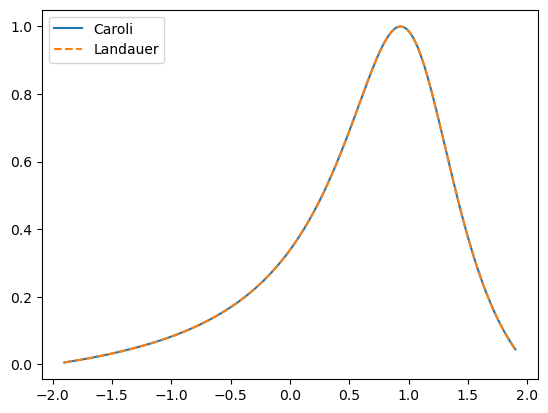

PyObject <matplotlib.legend.Legend object at 0x7f74be1b4e50>

In [131]:
plot(Es, Tcaroli, label = "Caroli")
plot(Es, Tlandauer, label = "Landauer", "--")
legend()